<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S10/blob/master/S10_Trial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


In [2]:
!pip install -U git+https://github.com/albu/albumentations


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-lj5hrlye
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-lj5hrlye
     |████████████████████████████████| 634kB 1.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65100 sha256=36a9f55cc4eee2a65d7c89122831ab971b315177576b5e03e4851a11c24b4617
  Stored in directory: /tmp/pip-ephem-wheel-cache-8o4z7wz9/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=cd7b70d2a321d372263ae9274c5cdf3ec5a0f9f41c66dd84e0dee619d8fd0014
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  

In [3]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
folder = '/content/gdrive/My Drive/Session10'
sys.path.append(folder)

In [5]:
import torch
import Albumentation
import show_images
import my_model
import train_test
import evaluate
import GradCam
import lr_finder

  pip install torch-lr-finder -v --global-option="amp"


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
classes, trainloader, testloader = Albumentation.album_Compose.load()

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



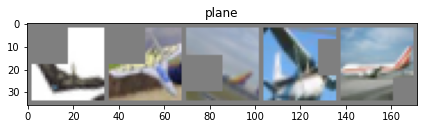

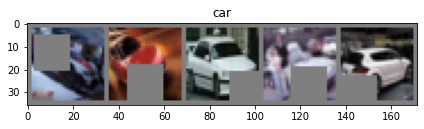

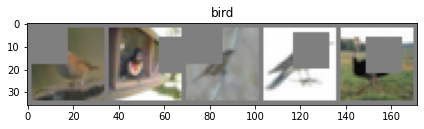

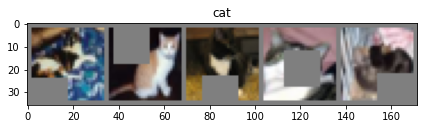

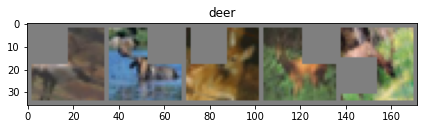

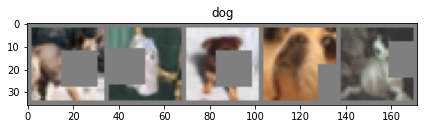

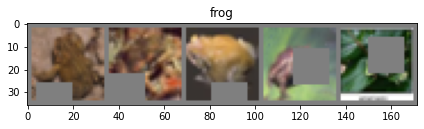

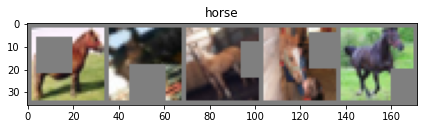

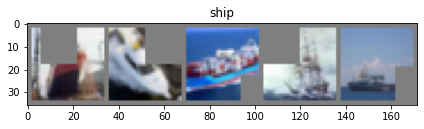

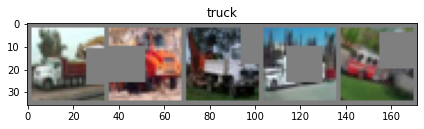

In [7]:
show_images.show_random_images(trainloader, classes)

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = my_model.ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(resnet.parameters(), lr=0.0001,momentum=0.9 ,weight_decay = 0.0005)
lrfinder = lr_finder.LRFinder(resnet, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=700 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


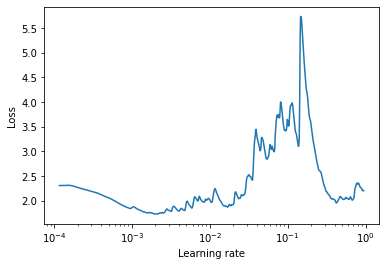

In [10]:
lrfinder.plot()


In [0]:
Best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]

In [0]:
lrfinder.reset()

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
scheduler = ReduceLROnPlateau(optimizer, patience = 7)#, min_lr=1e-4)

In [14]:
testLoss = []
testAcc = []
EPOCHS = 50
#best_acc1 = 10
for epoch in range(EPOCHS):
     print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(resnet, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(resnet, device, criterion, testloader)
     scheduler.step(test_loss[-1])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.002008432048839208


Loss=1.33054780960083 Batch_id=390 Accuracy=41.45: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 5176/10000 (51.76%)

EPOCH: 2 LR: 0.002008432048839208


Loss=1.1509034633636475 Batch_id=390 Accuracy=54.88: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0086, Accuracy: 6139/10000 (61.39%)

EPOCH: 3 LR: 0.002008432048839208


Loss=1.0904409885406494 Batch_id=390 Accuracy=61.39: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6852/10000 (68.52%)

EPOCH: 4 LR: 0.002008432048839208


Loss=0.612981915473938 Batch_id=390 Accuracy=65.44: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 7229/10000 (72.29%)

EPOCH: 5 LR: 0.002008432048839208


Loss=0.8347927331924438 Batch_id=390 Accuracy=68.78: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0060, Accuracy: 7307/10000 (73.07%)

EPOCH: 6 LR: 0.002008432048839208


Loss=0.7581602931022644 Batch_id=390 Accuracy=71.16: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7665/10000 (76.65%)

EPOCH: 7 LR: 0.002008432048839208


Loss=0.8179178237915039 Batch_id=390 Accuracy=72.86: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 7995/10000 (79.95%)

EPOCH: 8 LR: 0.002008432048839208


Loss=0.651032567024231 Batch_id=390 Accuracy=74.33: 100%|██████████| 391/391 [00:29<00:00, 13.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7775/10000 (77.75%)

EPOCH: 9 LR: 0.002008432048839208


Loss=0.6462081670761108 Batch_id=390 Accuracy=76.01: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8179/10000 (81.79%)

EPOCH: 10 LR: 0.002008432048839208


Loss=0.5010775327682495 Batch_id=390 Accuracy=77.00: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8051/10000 (80.51%)

EPOCH: 11 LR: 0.002008432048839208


Loss=0.6043606996536255 Batch_id=390 Accuracy=78.06: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 7887/10000 (78.87%)

EPOCH: 12 LR: 0.002008432048839208


Loss=0.5145372152328491 Batch_id=390 Accuracy=78.88: 100%|██████████| 391/391 [00:29<00:00, 13.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8289/10000 (82.89%)

EPOCH: 13 LR: 0.002008432048839208


Loss=0.4472643733024597 Batch_id=390 Accuracy=79.72: 100%|██████████| 391/391 [00:29<00:00, 13.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8294/10000 (82.94%)

EPOCH: 14 LR: 0.002008432048839208


Loss=0.562321126461029 Batch_id=390 Accuracy=80.38: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8448/10000 (84.48%)

EPOCH: 15 LR: 0.002008432048839208


Loss=0.4505457878112793 Batch_id=390 Accuracy=81.10: 100%|██████████| 391/391 [00:29<00:00, 13.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8490/10000 (84.90%)

EPOCH: 16 LR: 0.002008432048839208


Loss=0.6573491096496582 Batch_id=390 Accuracy=81.49: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8423/10000 (84.23%)

EPOCH: 17 LR: 0.002008432048839208


Loss=0.5263019800186157 Batch_id=390 Accuracy=82.46: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8422/10000 (84.22%)

EPOCH: 18 LR: 0.002008432048839208


Loss=0.3818845748901367 Batch_id=390 Accuracy=82.83: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8444/10000 (84.44%)

EPOCH: 19 LR: 0.002008432048839208


Loss=0.586089015007019 Batch_id=390 Accuracy=83.56: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8651/10000 (86.51%)

EPOCH: 20 LR: 0.002008432048839208


Loss=0.35570818185806274 Batch_id=390 Accuracy=83.67: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8577/10000 (85.77%)

EPOCH: 21 LR: 0.002008432048839208


Loss=0.2903062105178833 Batch_id=390 Accuracy=84.04: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8642/10000 (86.42%)

EPOCH: 22 LR: 0.002008432048839208


Loss=0.4727349877357483 Batch_id=390 Accuracy=84.85: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8640/10000 (86.40%)

EPOCH: 23 LR: 0.002008432048839208


Loss=0.4483099579811096 Batch_id=390 Accuracy=85.25: 100%|██████████| 391/391 [00:29<00:00, 13.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8731/10000 (87.31%)

EPOCH: 24 LR: 0.002008432048839208


Loss=0.6310933232307434 Batch_id=390 Accuracy=85.59: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8556/10000 (85.56%)

EPOCH: 25 LR: 0.002008432048839208


Loss=0.3977544903755188 Batch_id=390 Accuracy=85.94: 100%|██████████| 391/391 [00:29<00:00, 13.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8752/10000 (87.52%)

EPOCH: 26 LR: 0.002008432048839208


Loss=0.5463542342185974 Batch_id=390 Accuracy=86.33: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8788/10000 (87.88%)

EPOCH: 27 LR: 0.002008432048839208


Loss=0.2299443781375885 Batch_id=390 Accuracy=86.55: 100%|██████████| 391/391 [00:29<00:00, 13.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 8818/10000 (88.18%)

EPOCH: 28 LR: 0.002008432048839208


Loss=0.42494821548461914 Batch_id=390 Accuracy=86.93: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8514/10000 (85.14%)

EPOCH: 29 LR: 0.002008432048839208


Loss=0.37489527463912964 Batch_id=390 Accuracy=87.25: 100%|██████████| 391/391 [00:29<00:00, 13.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8819/10000 (88.19%)

EPOCH: 30 LR: 0.002008432048839208


Loss=0.25774767994880676 Batch_id=390 Accuracy=87.61: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8863/10000 (88.63%)

EPOCH: 31 LR: 0.002008432048839208


Loss=0.40748968720436096 Batch_id=390 Accuracy=88.02: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8660/10000 (86.60%)

EPOCH: 32 LR: 0.002008432048839208


Loss=0.26129451394081116 Batch_id=390 Accuracy=88.03: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8824/10000 (88.24%)

EPOCH: 33 LR: 0.002008432048839208


Loss=0.47115278244018555 Batch_id=390 Accuracy=88.29: 100%|██████████| 391/391 [00:29<00:00, 13.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8819/10000 (88.19%)

EPOCH: 34 LR: 0.002008432048839208


Loss=0.4101351201534271 Batch_id=390 Accuracy=88.48: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8819/10000 (88.19%)

EPOCH: 35 LR: 0.002008432048839208


Loss=0.34080591797828674 Batch_id=390 Accuracy=88.72: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0029, Accuracy: 8857/10000 (88.57%)

EPOCH: 36 LR: 0.0002008432048839208


Loss=0.2415614128112793 Batch_id=390 Accuracy=90.96: 100%|██████████| 391/391 [00:29<00:00, 13.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9087/10000 (90.87%)

EPOCH: 37 LR: 0.0002008432048839208


Loss=0.2766457200050354 Batch_id=390 Accuracy=92.00: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9091/10000 (90.91%)

EPOCH: 38 LR: 0.0002008432048839208


Loss=0.16086430847644806 Batch_id=390 Accuracy=92.21: 100%|██████████| 391/391 [00:29<00:00, 13.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9117/10000 (91.17%)

EPOCH: 39 LR: 0.0002008432048839208


Loss=0.1507374793291092 Batch_id=390 Accuracy=92.43: 100%|██████████| 391/391 [00:29<00:00, 13.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9116/10000 (91.16%)

EPOCH: 40 LR: 0.0002008432048839208


Loss=0.1793738454580307 Batch_id=390 Accuracy=92.60: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0021, Accuracy: 9103/10000 (91.03%)

EPOCH: 41 LR: 0.0002008432048839208


Loss=0.12270202487707138 Batch_id=390 Accuracy=92.64: 100%|██████████| 391/391 [00:29<00:00, 13.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9092/10000 (90.92%)

EPOCH: 42 LR: 0.0002008432048839208


Loss=0.14057542383670807 Batch_id=390 Accuracy=92.89: 100%|██████████| 391/391 [00:29<00:00, 13.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9092/10000 (90.92%)

EPOCH: 43 LR: 0.0002008432048839208


Loss=0.3554776608943939 Batch_id=390 Accuracy=93.02: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9098/10000 (90.98%)

EPOCH: 44 LR: 0.0002008432048839208


Loss=0.1357523500919342 Batch_id=390 Accuracy=93.22: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9102/10000 (91.02%)

EPOCH: 45 LR: 0.0002008432048839208


Loss=0.21268562972545624 Batch_id=390 Accuracy=93.10: 100%|██████████| 391/391 [00:29<00:00, 13.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9102/10000 (91.02%)

EPOCH: 46 LR: 0.0002008432048839208


Loss=0.18695712089538574 Batch_id=390 Accuracy=93.26: 100%|██████████| 391/391 [00:29<00:00, 13.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9115/10000 (91.15%)

EPOCH: 47 LR: 0.0002008432048839208


Loss=0.21860599517822266 Batch_id=390 Accuracy=93.17: 100%|██████████| 391/391 [00:29<00:00, 13.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9123/10000 (91.23%)

EPOCH: 48 LR: 0.0002008432048839208


Loss=0.21222081780433655 Batch_id=390 Accuracy=93.53: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9114/10000 (91.14%)

EPOCH: 49 LR: 2.0084320488392084e-05


Loss=0.2368277609348297 Batch_id=390 Accuracy=93.64: 100%|██████████| 391/391 [00:29<00:00, 13.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9121/10000 (91.21%)

EPOCH: 50 LR: 2.0084320488392084e-05


Loss=0.1495160460472107 Batch_id=390 Accuracy=93.52: 100%|██████████| 391/391 [00:29<00:00, 13.28it/s]



Test set: Average loss: 0.0022, Accuracy: 9126/10000 (91.26%)



In [15]:
evaluate.evaluate_accuracy(resnet, device, testloader)

Accuracy of the network on the 10000 test images: 91.260 %


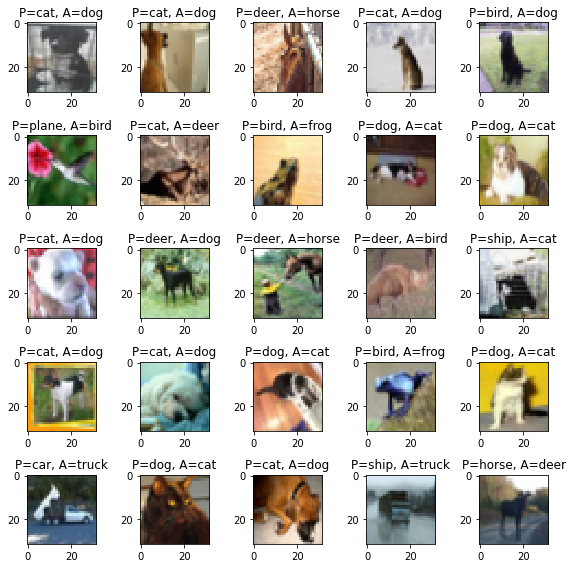

In [16]:
misclassified_images = evaluate.show_misclassified_images(resnet, device, testloader, classes)

In [17]:
evaluate.evaluate_classwise_accuracy(resnet, device, classes, testloader)

Accuracy of plane : 91 %
Accuracy of   car : 88 %
Accuracy of  bird : 90 %
Accuracy of   cat : 79 %
Accuracy of  deer : 87 %
Accuracy of   dog : 73 %
Accuracy of  frog : 89 %
Accuracy of horse : 96 %
Accuracy of  ship : 97 %
Accuracy of truck : 100 %


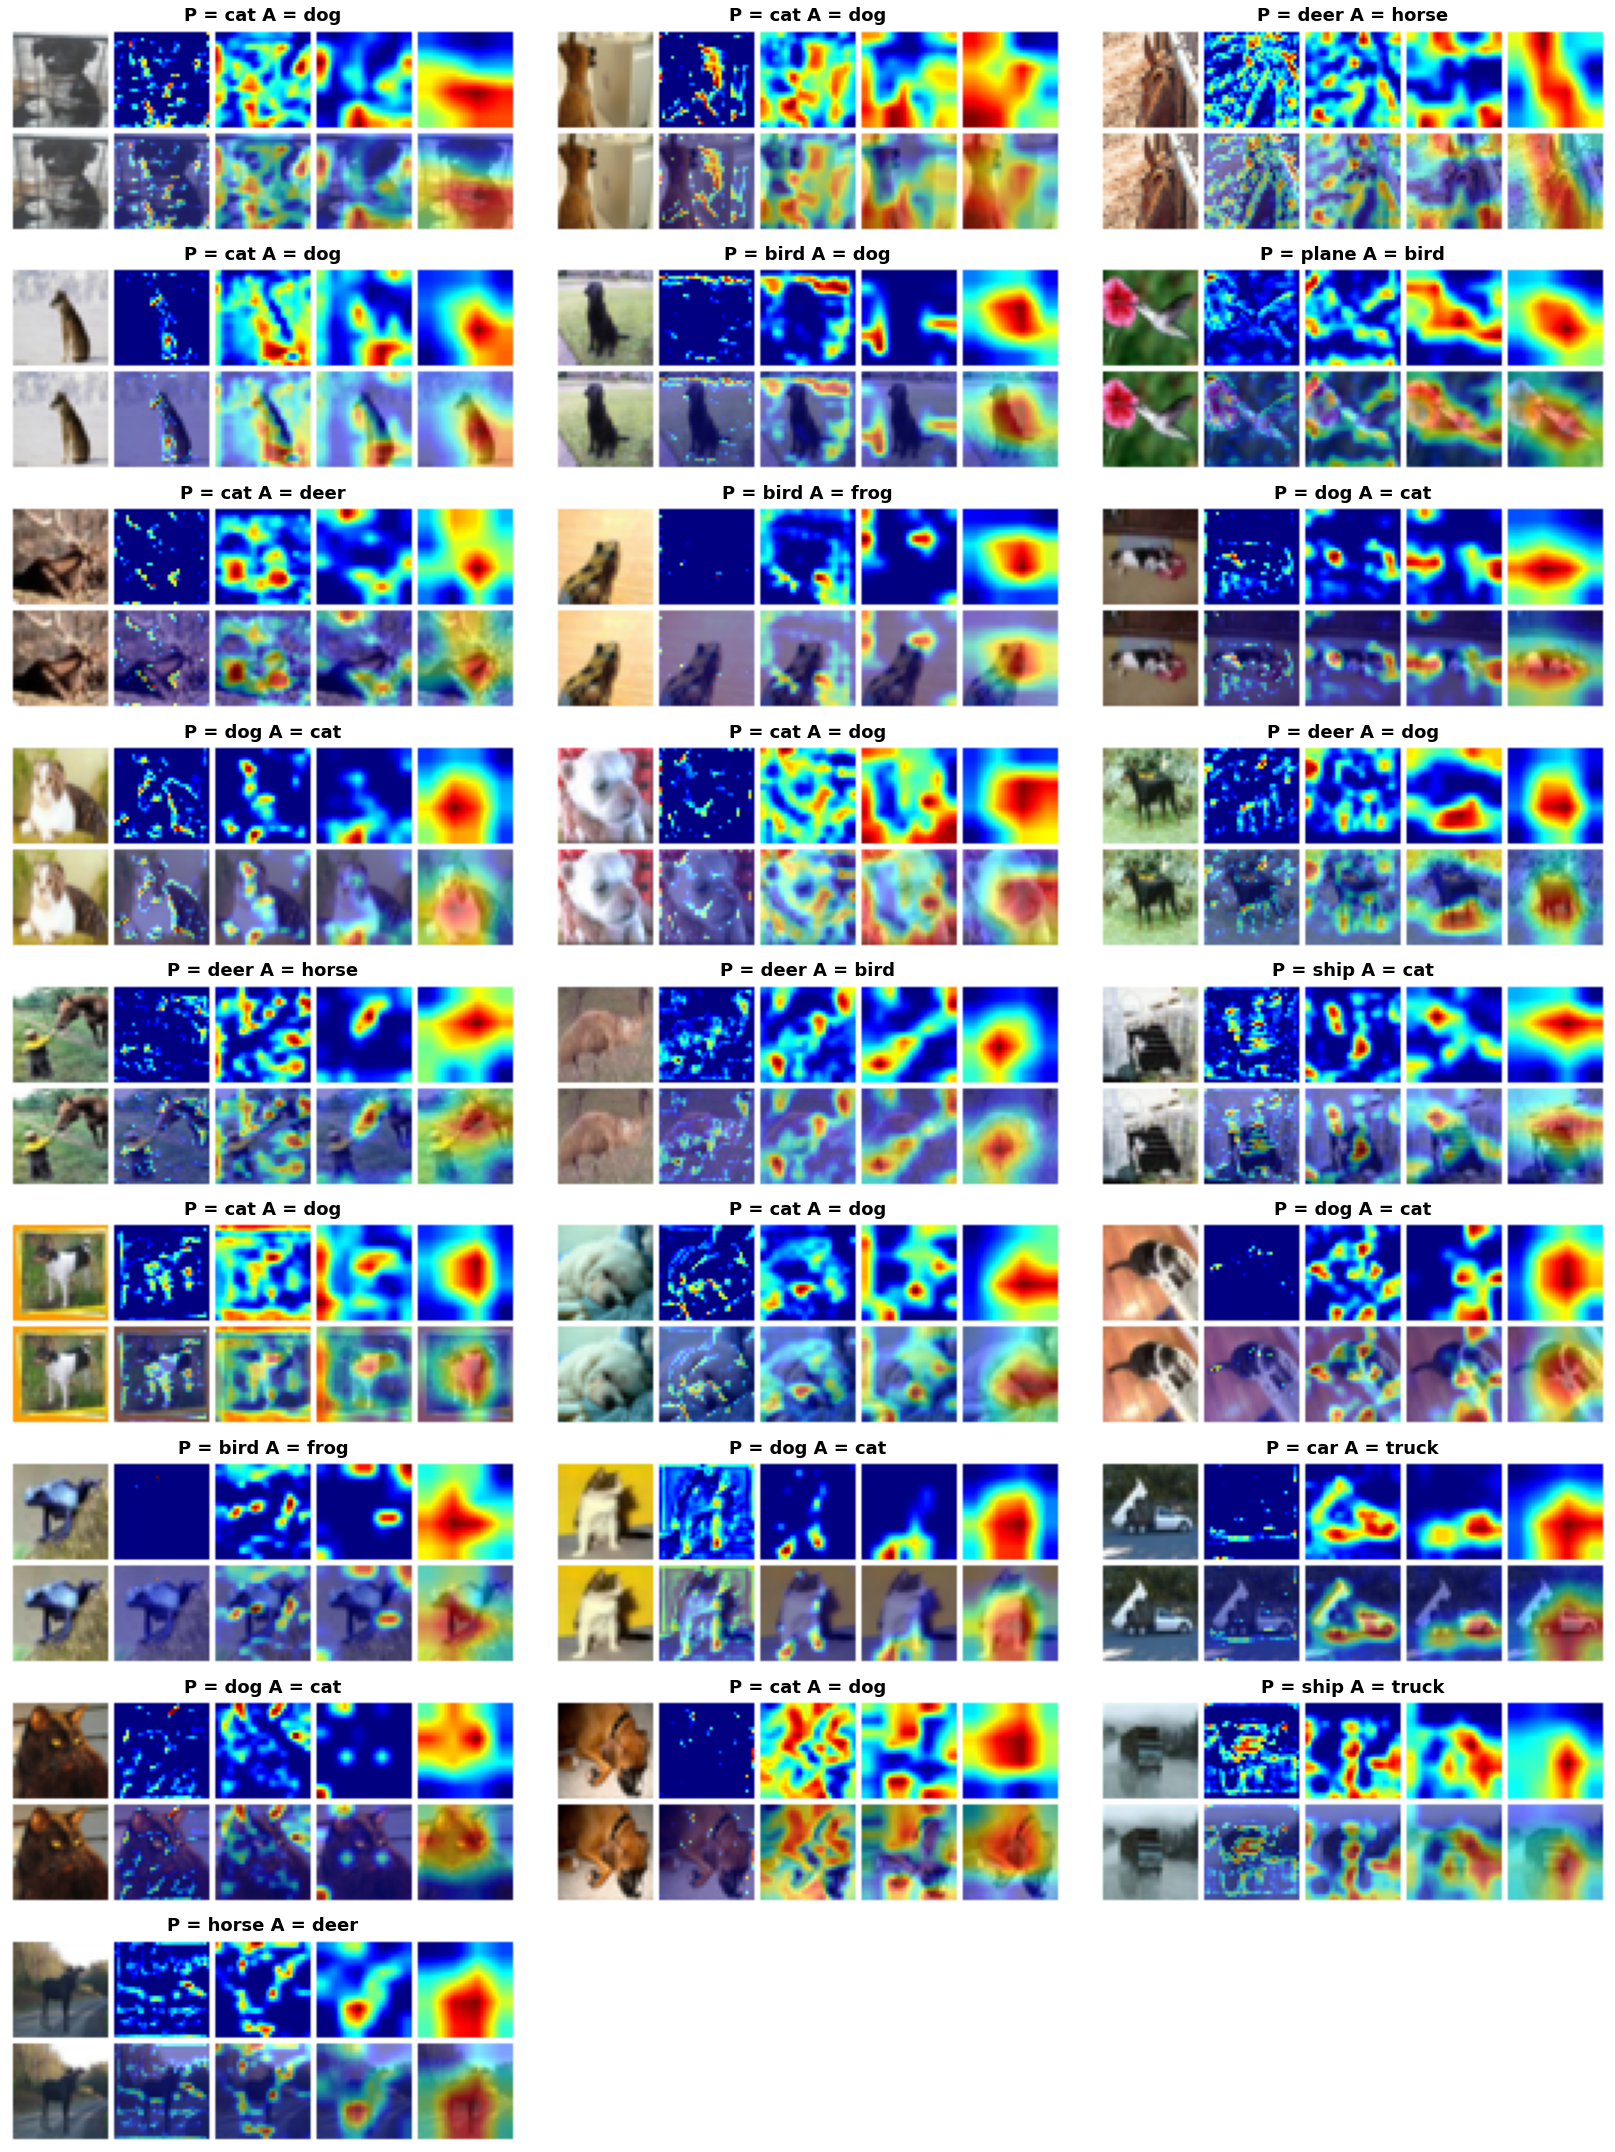

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from torchvision.utils import make_grid, save_image
fig = plt.figure(figsize=(23,30))
for i,k in enumerate(misclassified_images):
  images1 = [misclassified_images[i][0].cpu()/2+0.5]
  images2 =  [misclassified_images[i][0].cpu()/2+0.5]
  b = resnet.to(device)
  # output = model(misclassified_images[i][0])
  # _, predicted = torch.max(output.data, 1)
  #print(classes[int(predicted)])
  layers =  [resnet.layer1,resnet.layer2,resnet.layer3,resnet.layer4]
  for j in layers:
    g = GradCam.GradCAM(b,j)
    mask, _= g(misclassified_images[i][0].clone().unsqueeze_(0))
    heatmap, result = GradCam.GradCAM.visualize_cam(mask,misclassified_images[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5,pad_value=1)
  npimg = grid_image.numpy()
  sub = fig.add_subplot(9, 3, i+1) 
 
  # fig.subplots_adjust(wspace=0)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  sub.set_title('P = '+classes[int(misclassified_images[i][1])]+" A = "+classes[int(misclassified_images[i][2])],fontweight="bold",fontsize=18)
  sub.axis("off")
plt.tight_layout()
fig.subplots_adjust(wspace=0)